# Metropolis Hastings Markov Chain Monte Carlo (MH-MCMC)

In this notebook, we will be walking through a simple example of sampling using MH MCMC. First we need to import jax and the sampling tools.

In [1]:
from energax.sampling.discrete import DiscreteUniformMH
from energax.utils import int_to_bin
import jax
import equinox as eqx
from jax import numpy as jnp
import matplotlib.pyplot as plt

Now we need to define out log probability function. In this case, we will be using a normal distribution over a discrete domain. 

In [2]:
class E(eqx.Module):
    def __call__(self, x):
        u = jnp.sum(2 ** jnp.arange(len(x) - 1, -1, -1) * x) / 2 ** (len(x) - 1)
        return (u - 1) ** 2

    @staticmethod
    def energy_function(x):
        u = jnp.sum(2 ** jnp.arange(len(x) - 1, -1, -1) * x) / 2 ** (len(x) - 1)
        return (u - 1) ** 2


def p(x):
    return jnp.exp(-E.energy_function(x))


def bin_to_int(x):
    return jnp.sum(2 ** jnp.arange(len(x) - 1, -1, -1) * x)

In [3]:
dim = 4
key = jax.random.PRNGKey(42)
s = jnp.arange(2**dim)
basis_states = int_to_bin(s, dim)

Now we chose to use the uniform sampler.

In [4]:
step_u = DiscreteUniformMH((dim,), 10, 1000, 1)

We can see the analytic solution below.

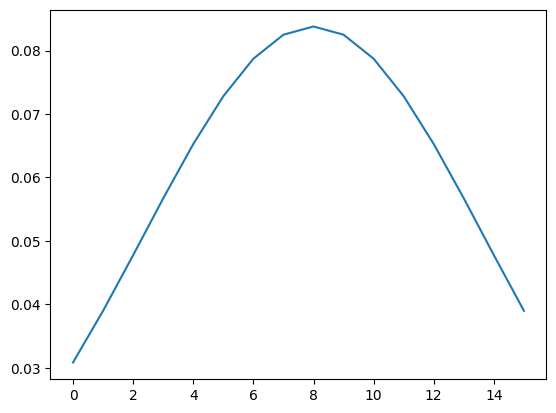

In [5]:
probs = jax.vmap(p)(basis_states)
probs = probs / sum(probs)
plt.plot(probs)
plt.show()

Let's get the results for many MCMC steps.

In [6]:
steps = 6_000
init_state = basis_states[0]
states = step_u.sample_chains(E(), init_state, key)

In [7]:
counters = jax.vmap(lambda x: bin_to_int(x))(states["position"][0])

In [8]:
vals = [0] * 2**dim
for i in counters:
    vals[i] += 1
vals = jnp.array(vals) / sum(vals)

Comparing the two we can see how MCMC has (roughly) converged to the target distribution.

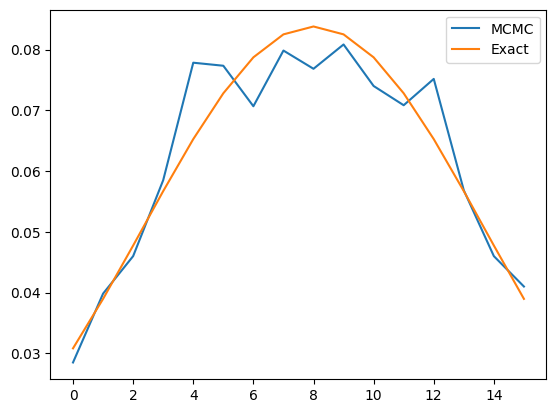

In [9]:
plt.plot(vals, label="MCMC")
plt.plot(probs, label="Exact")
plt.legend()
plt.show()